## Inference in non-Gaussian stochastic volatility models

This tutorial demonstrates inference using the Levy [Stable](http://docs.pyro.ai/en/stable/distributions.html#stable) distribution.

In [1]:
import math
import os
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.infer import EnergyDistance, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, SymmetricStableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']

assert pyro.__version__.startswith('1.1.0')
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)

In [2]:
df = pd.read_csv(os.path.expanduser("~/Downloads/snp500.csv"))
#df = pd.read_csv(os.path.expanduser("~/Downloads/KO.csv"))

In [3]:
x = torch.tensor(df["Close"]).float()
x.shape

torch.Size([23083])

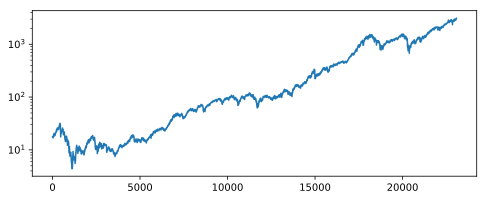

In [4]:
pyplot.figure(figsize=(8, 3))
pyplot.plot(x)
pyplot.yscale('log')

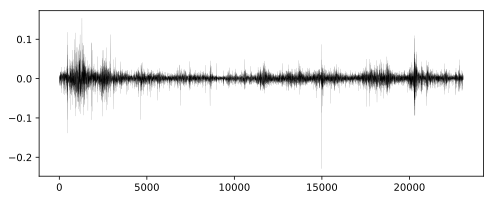

In [5]:
pyplot.figure(figsize=(8, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1);

mean = 0.00022394036932382733
std = 0.011869287118315697


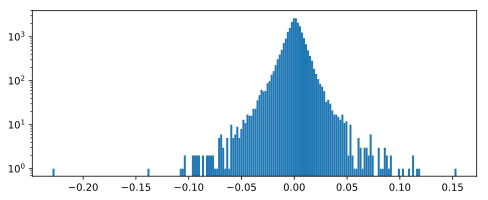

In [6]:
pyplot.figure(figsize=(8, 3))
pyplot.hist(r, bins=200)
pyplot.yscale('log')
print("mean = {}".format(r.mean()))
print("std = {}".format(r.std()))

First let's fit a single distribution to the returns.

In [7]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 8.169078826904297
step 20 loss = 2.480233669281006
step 40 loss = 2.322582960128784
step 60 loss = 1.3298510313034058
step 80 loss = 1.296791434288025
step 100 loss = 1.2887918949127197
step 120 loss = 1.315025806427002
step 140 loss = 1.2715963125228882
step 160 loss = 1.2690484523773193
step 180 loss = 1.2737268209457397
step 200 loss = 1.2896374464035034
loc = 0.00019957474432885647
scale = 0.008347502909600735
stability = 1.979245662689209
CPU times: user 15.8 s, sys: 490 ms, total: 16.3 s
Wall time: 2.42 s


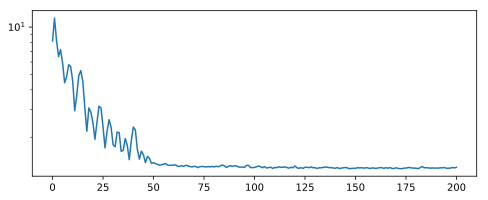

In [8]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))

pyplot.figure(figsize=(8, 3))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

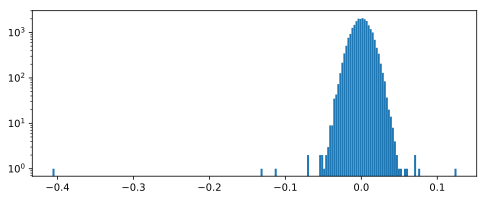

In [9]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(8, 3), dpi=300)
pyplot.hist(samples, bins=200)
pyplot.yscale('log')

This is a poor fit, but that was to be expected since we are mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling in Pyro

Consider a stochastic volatity model of the log returns `r_t` and a latent volatility `h`:
$$
  \log h_t = \delta + \phi \log h_{t-1} + \sigma v_t \\
  r_t = w_t \sqrt{h_t}
$$
Usually $\sigma v_1$ and $w_t$ are both Gaussian. We will generalize to a symmetric Stable distributoin for $\sigma v_t$.

In [10]:
def model(data):
    # We model volatility as a Gaussian process, where h_noise are the independent increments.
    # Note we use .to_event(1) rather than plate() because we'll later reparameterize along
    # the time axis using DiscreteCosineReparam, breaking independence.
    h_scale = pyro.sample("h_scale", dist.LogNormal(0, 1))
    h_loc = pyro.sample("h_loc", dist.Normal(0, 1e-2))
    h_noise = pyro.sample("h_noise", dist.Normal(0, 1).expand([len(data)]).to_event(1))
    log_h = pyro.deterministic("log_h", h_loc + h_scale * h_noise.cumsum(dim=-1))

    # Observed log returns, assumed to be a symmetric Stable distribution.
    r_stability = pyro.sample("r_stability", dist.Uniform(1.01, 1.99))
    r_scale = log_h.mul(0.5).exp()
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2))
    with pyro.plate("time", len(data)):
        pyro.sample("r", dist.Stable(r_stability, 0., r_scale, r_loc), obs=data)

step 0 loss = 7.75253e+06
step 50 loss = 24.0865
step 100 loss = -1.15328
step 150 loss = -1.54548
step 200 loss = -2.60192
step 250 loss = -2.7825
step 300 loss = -2.81773
step 350 loss = -2.94011
step 400 loss = -2.68867
step 450 loss = -3.15299
step 500 loss = -3.12195
step 550 loss = -3.15825
step 600 loss = -3.15674
step 650 loss = -3.16653
step 700 loss = -3.14125
step 750 loss = -3.17703
step 800 loss = -3.1889
step 850 loss = -3.19269
step 900 loss = -3.18027
step 950 loss = -3.18836
step 1000 loss = -3.1946
h_loc = -0.002921279286965728
h_scale = 0.12301060557365417
r_loc = 0.0008381743100471795
r_stability = 1.9738421440124512


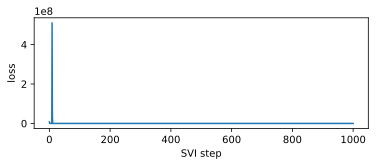

In [11]:
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 1001
optim = ClippedAdam({"lr": 0.1,
                     "betas": (0.9, 0.99),
                     "lrd": 0.01 ** (1 / num_steps)})
reparam_model = poutine.reparam(model, {"h_noise": DiscreteCosineReparam(),
                                        "r": SymmetricStableReparam()})
guide = AutoDiagonalNormal(reparam_model)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r) / len(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}".format(step, loss))

pyplot.figure(figsize=(6,2))
pyplot.plot(losses)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

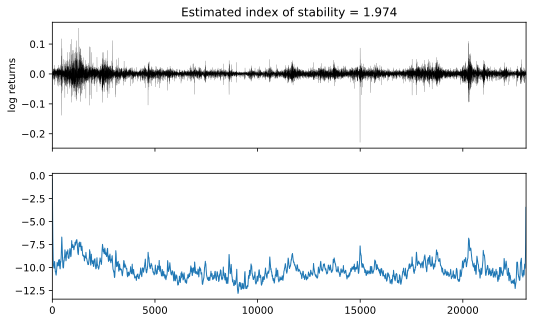

In [12]:
fig, axes = pyplot.subplots(2, figsize=(8.5, 5), sharex=True)
axes[0].plot(r, "k", lw=0.2)
axes[0].set_ylabel("log returns")
axes[0].set_xlim(0, len(r))

# We will pull out median log returns using the autoguide's .median() and poutines.
with torch.no_grad():
    median = guide.median()
    trace = poutine.trace(poutine.condition(reparam_model, median)).get_trace(r)
    log_h = trace.nodes["log_h"]["value"]
    stability = trace.nodes["r_stability"]["value"].item()
axes[1].plot(log_h, lw=1)
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability));